In [1]:
# --- Импорты ---
import os
import datetime
import multiprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import requests

import torchvision
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import importlib

In [ ]:
# --- Гиперпараметры обучения и модели ---
VAE_W = 2 # Версия VAE
SIMPLE_LOSS = False

BATCH_SIZE = 128 #4 # Размер пакета данных для одной итерации обучения.Большее значение ускоряет обучение, но требует больше видеопамяти.
LATENT_DIM = 128 #2 # Размерность латентного пространства (вектора z). # Чем больше размерность, тем богаче потенциальная вариативность генерируемых изображений.
IMAGE_SIZE = 256 #2 # Размер входных изображений (высота и ширина в пикселях).# Должен быть кратным 16 для корректной работы архитектуры энкодера и декодера.

EPOCHS = 300
EARLY_STOP = 20 #30 # Общее количество проходов по всему датасету во время обучения.

SAVE_INTERVAL = 5 # Интервал в эпохах для сохранения сгенерированных изображений в процессе обучения.

OLD_MODEL = './models/vae_model_V3.pth' #False
SAVE_PATH = './models/vae_model_V4.pth'# Путь для сохранения финальной версии обученной модели.

LEARNING_RATE = 1e-3 # Скорость обучения оптимизатора.  # Малое значение приводит к медленному обучению, большое может вызывать нестабильность.

In [3]:
#Folders
OUTPUT = './output'
EPOCHS_FOLDER = os.path.join(OUTPUT, 'epochs')
EPOCHS_FOLDER_REAL = os.path.join(OUTPUT, 'epochs_real')
GENERATED_FOLDER = os.path.join(OUTPUT, 'generated')
MORPH_FOLDER = os.path.join(OUTPUT, 'morph_frames')
Z_FOLDER = os.path.join(OUTPUT, 'z_frames')
LAT_GRID = os.path.join(OUTPUT, 'latent_frames')
GRID_FOLDER = os.path.join(OUTPUT, 'grid')
os.makedirs(OUTPUT, exist_ok=True)
os.makedirs(EPOCHS_FOLDER, exist_ok=True)
os.makedirs(EPOCHS_FOLDER_REAL, exist_ok=True)
os.makedirs(GENERATED_FOLDER, exist_ok=True)
os.makedirs(MORPH_FOLDER, exist_ok=True)
os.makedirs(Z_FOLDER, exist_ok=True)
os.makedirs(LAT_GRID, exist_ok=True)
os.makedirs(GRID_FOLDER, exist_ok=True)

In [4]:
# Создание загрузчиков данных
num_workers = min(16, multiprocessing.cpu_count())
prefetch_factor = 128 * 1

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")
with torch.no_grad():
    torch.cuda.empty_cache()

Using DEVICE: cuda


In [6]:
# Подготовка данных
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [7]:
dataset = datasets.ImageFolder(root='data', transform=transform)
#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # обязательно перемешивание
    num_workers=num_workers,           # или другое оптимальное число
    pin_memory=True,
    prefetch_factor=prefetch_factor,       # если много CPU
    persistent_workers=True  # если поддерживается версией
)

print(f"Загрузил: {len(dataset)} Изображеннй")

Загрузил: 1800 Изображеннй


In [8]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [9]:
# Вспомогательные функции
def plot_loss(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('График изменения потерь')
    plt.legend()
    plt.show()

def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [10]:
#ВАЛИДАЦИЯ ПО ЭПОХАМ НА РЕАЛЬНЫХ ФОТО
NUM_PIC = 32
real_dataset = datasets.ImageFolder(root='data', transform=transform)
real_loader = DataLoader(real_dataset, batch_size=NUM_PIC, shuffle=True)

real_imgs, _ = next(iter(real_loader))
real_imgs = real_imgs.to(DEVICE)

In [11]:
# Инициализация модели
if OLD_MODEL:
    checkpoint = torch.load(OLD_MODEL, map_location=DEVICE)
    VAE_W = checkpoint['v']
    module = importlib.import_module(f'VAE.vae_v{VAE_W}')
    VAE = module.VAE
    LATENT_DIM = checkpoint['LATENT_DIM']
    IMAGE_SIZE = checkpoint['IMAGE_SIZE']
    BATCH_SIZE = checkpoint['BATCH_SIZE']
    vae = VAE(LATENT_DIM, IMAGE_SIZE).to(DEVICE)
    vae.load_state_dict(checkpoint['model'])
    OLD_EPOCH = checkpoint['EPOCH']
    print(f"Loaded model from: {OLD_MODEL} | OLD_EPOCH: {OLD_EPOCH}")
    print(f'VAE_V: {VAE_W} | IMAGE_SIZE: {IMAGE_SIZE} | LATENT_DIM: {LATENT_DIM} | BATCH_SIZE: {BATCH_SIZE}')
else:
    OLD_EPOCH = 0
    module = importlib.import_module(f'VAE.vae_v{VAE_W}')
    VAE = module.VAE
    vae = VAE(LATENT_DIM, IMAGE_SIZE).to(DEVICE)
perceptual_loss_fn = module.VGGPerceptualLoss(device=DEVICE).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

Loaded model from: ./models/vae_model_V3.pth | OLD_EPOCH: 357
VAE_V: 2 | IMAGE_SIZE: 256 | LATENT_DIM: 128 | BATCH_SIZE: 128


In [12]:
# Обучение модели
losses = []
best_loss = float('inf')
best_model = vae
epoch = 0


Epoch [1/300]
Train Loss: 5.8681 (Recon: 5.6438, KL: 4.4863)
Время: 0:02:19
Все время: 0:02:19

Epoch [2/300]
Train Loss: 4.9663 (Recon: 4.7567, KL: 4.1933)
Время: 0:00:27
Все время: 0:00:27

Epoch [3/300]
Train Loss: 4.7366 (Recon: 4.5498, KL: 3.7356)
Время: 0:00:25
Все время: 0:00:25

Epoch [4/300]
Train Loss: 4.6967 (Recon: 4.5185, KL: 3.5650)
Время: 0:00:25
Все время: 0:00:25

Epoch [5/300]
Train Loss: 4.5963 (Recon: 4.4266, KL: 3.3937)
Время: 0:00:26


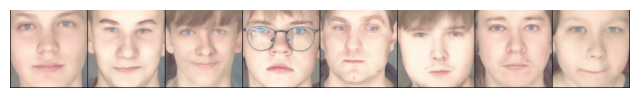

Все время: 0:00:27

Epoch [6/300]
Train Loss: 4.6196 (Recon: 4.4461, KL: 3.4696)
Время: 0:00:27
val_loss: 4.6196 > best_loss: 4.5963, попытка 1
Все время: 0:00:27

Epoch [7/300]
Train Loss: 4.6453 (Recon: 4.4781, KL: 3.3437)
Время: 0:00:26
val_loss: 4.6453 > best_loss: 4.5963, попытка 2
Все время: 0:00:26

Epoch [8/300]
Train Loss: 4.6077 (Recon: 4.4434, KL: 3.2854)
Время: 0:00:25
val_loss: 4.6077 > best_loss: 4.5963, попытка 3
Все время: 0:00:25

Epoch [9/300]
Train Loss: 4.6720 (Recon: 4.5060, KL: 3.3191)
Время: 0:00:26
val_loss: 4.6720 > best_loss: 4.5963, попытка 4
Все время: 0:00:26

Epoch [10/300]
Train Loss: 4.5999 (Recon: 4.4308, KL: 3.3828)
Время: 0:00:26
val_loss: 4.5999 > best_loss: 4.5963, попытка 5


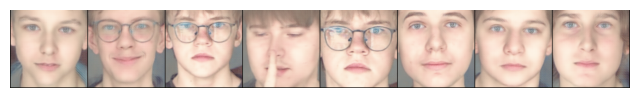

Все время: 0:00:26

Epoch [11/300]
Train Loss: 4.6041 (Recon: 4.4383, KL: 3.3148)
Время: 0:00:25
val_loss: 4.6041 > best_loss: 4.5963, попытка 6
Все время: 0:00:25

Epoch [12/300]
Train Loss: 4.5784 (Recon: 4.4182, KL: 3.2039)
Время: 0:00:25
Все время: 0:00:25

Epoch [13/300]
Train Loss: 4.5443 (Recon: 4.3871, KL: 3.1434)
Время: 0:00:25
Все время: 0:00:25

Epoch [14/300]
Train Loss: 4.5512 (Recon: 4.3955, KL: 3.1140)
Время: 0:00:26
val_loss: 4.5512 > best_loss: 4.5443, попытка 1
Все время: 0:00:26

Epoch [15/300]
Train Loss: 4.5703 (Recon: 4.4188, KL: 3.0308)
Время: 0:00:27
val_loss: 4.5703 > best_loss: 4.5443, попытка 2


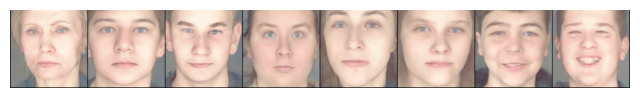

Все время: 0:00:27

Epoch [16/300]
Train Loss: 4.5986 (Recon: 4.4394, KL: 3.1825)
Время: 0:00:26
val_loss: 4.5986 > best_loss: 4.5443, попытка 3
Все время: 0:00:26

Epoch [17/300]
Train Loss: 4.6334 (Recon: 4.4746, KL: 3.1752)
Время: 0:00:26
val_loss: 4.6334 > best_loss: 4.5443, попытка 4
Все время: 0:00:26

Epoch [18/300]
Train Loss: 4.6228 (Recon: 4.4506, KL: 3.4451)
Время: 0:00:27
val_loss: 4.6228 > best_loss: 4.5443, попытка 5
Все время: 0:00:27

Epoch [19/300]
Train Loss: 4.5772 (Recon: 4.4130, KL: 3.2841)
Время: 0:00:25
val_loss: 4.5772 > best_loss: 4.5443, попытка 6
Все время: 0:00:25

Epoch [20/300]
Train Loss: 4.5646 (Recon: 4.4013, KL: 3.2654)
Время: 0:00:26
val_loss: 4.5646 > best_loss: 4.5443, попытка 7


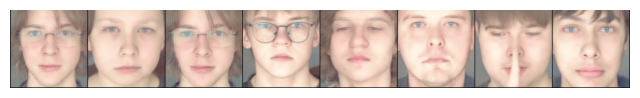

Все время: 0:00:27

Epoch [21/300]
Train Loss: 4.5738 (Recon: 4.4154, KL: 3.1673)
Время: 0:00:26
val_loss: 4.5738 > best_loss: 4.5443, попытка 8
Все время: 0:00:26

Epoch [22/300]
Train Loss: 4.5494 (Recon: 4.3912, KL: 3.1631)
Время: 0:00:25
val_loss: 4.5494 > best_loss: 4.5443, попытка 9
Все время: 0:00:25

Epoch [23/300]
Train Loss: 4.5659 (Recon: 4.4071, KL: 3.1757)
Время: 0:00:26
val_loss: 4.5659 > best_loss: 4.5443, попытка 10
Все время: 0:00:26

Epoch [24/300]
Train Loss: 4.5499 (Recon: 4.3869, KL: 3.2611)
Время: 0:00:27
val_loss: 4.5499 > best_loss: 4.5443, попытка 11
Все время: 0:00:27

Epoch [25/300]
Train Loss: 4.5275 (Recon: 4.3739, KL: 3.0722)
Время: 0:00:27


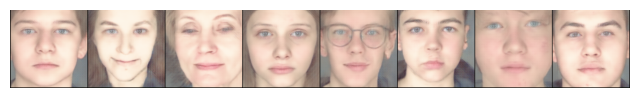

Все время: 0:00:27

Epoch [26/300]
Train Loss: 4.5299 (Recon: 4.3729, KL: 3.1392)
Время: 0:00:27
val_loss: 4.5299 > best_loss: 4.5275, попытка 1
Все время: 0:00:27

Epoch [27/300]
Train Loss: 4.5442 (Recon: 4.3874, KL: 3.1357)
Время: 0:00:25
val_loss: 4.5442 > best_loss: 4.5275, попытка 2
Все время: 0:00:25

Epoch [28/300]
Train Loss: 4.5430 (Recon: 4.3848, KL: 3.1636)
Время: 0:00:26
val_loss: 4.5430 > best_loss: 4.5275, попытка 3
Все время: 0:00:26

Epoch [29/300]
Train Loss: 4.4497 (Recon: 4.2964, KL: 3.0674)
Время: 0:00:25
Все время: 0:00:25

Epoch [30/300]
Train Loss: 4.4576 (Recon: 4.3098, KL: 2.9563)
Время: 0:00:26
val_loss: 4.4576 > best_loss: 4.4497, попытка 1


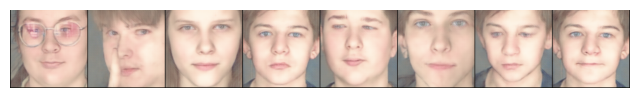

Все время: 0:00:27

Epoch [31/300]
Train Loss: 4.5274 (Recon: 4.3738, KL: 3.0723)
Время: 0:00:26
val_loss: 4.5274 > best_loss: 4.4497, попытка 2
Все время: 0:00:26

Epoch [32/300]
Train Loss: 4.4843 (Recon: 4.3318, KL: 3.0494)
Время: 0:00:26
val_loss: 4.4843 > best_loss: 4.4497, попытка 3
Все время: 0:00:26

Epoch [33/300]
Train Loss: 4.4700 (Recon: 4.3212, KL: 2.9771)
Время: 0:00:26
val_loss: 4.4700 > best_loss: 4.4497, попытка 4
Все время: 0:00:26

Epoch [34/300]
Train Loss: 4.4323 (Recon: 4.2773, KL: 3.1001)
Время: 0:00:26
Все время: 0:00:26

Epoch [35/300]
Train Loss: 4.4362 (Recon: 4.2928, KL: 2.8662)
Время: 0:00:27
val_loss: 4.4362 > best_loss: 4.4323, попытка 1


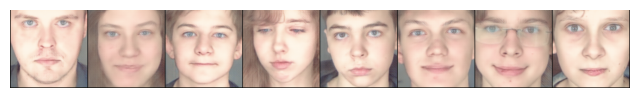

Все время: 0:00:28


In [ ]:
for epoch in range(EPOCHS):
    tstart = datetime.datetime.now()
    vae.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0

    for imgs, _ in dataloader:
        imgs = imgs.to(DEVICE)
        optimizer.zero_grad()
        recon_imgs, mu, logvar = vae(imgs)
        
        if SIMPLE_LOSS:
            loss = loss_function(recon_imgs, imgs, mu, logvar)
        else:
            # Перцептуальная + KL-дивергенция
            perceptual = perceptual_loss_fn(recon_imgs, imgs)
            kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = perceptual + 0.05 * kl  # веса можно регулировать

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        if SIMPLE_LOSS == False:
            recon_loss_total += perceptual.item()
            kl_loss_total += kl.item()

    avg_loss = train_loss / len(dataloader)
    if SIMPLE_LOSS == False:
        avg_recon_loss = recon_loss_total / len(dataloader)
        avg_kl_loss = kl_loss_total / len(dataloader)
    else:
        avg_recon_loss = 0
        avg_kl_loss = 0

    losses.append(avg_loss)

    print(f"\nEpoch [{epoch + 1}/{EPOCHS}]")
    print(f"Train Loss: {avg_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f})")
    print(f"Время: {str(datetime.datetime.now() - tstart).split('.')[0]}")

    # Сохраняем лучшую модель
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model = vae
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"val_loss: {avg_loss:.4f} > best_loss: {best_loss:.4f}, попытка {patience_counter}")
        if patience_counter >= EARLY_STOP:
            print("Ранняя остановка!")
            break

    # Периодическая генерация
    if (epoch + 1) % SAVE_INTERVAL == 0:
        vae.eval()
        if 1>5:
            with torch.no_grad():
                z = torch.randn(4, LATENT_DIM).to(DEVICE)
                samples = vae.decoder(z)
            vutils.save_image(samples.cpu(), f'{EPOCHS_FOLDER}/generated_faces_epoch_{epoch+1}.png', nrow=4)

        with torch.no_grad():
            mu, logvar = vae.encoder(imgs)
            z = vae.reparameterize(mu, logvar)
            samples = vae.decoder(z)
            vutils.save_image(samples.cpu(), f'{EPOCHS_FOLDER_REAL}/z_from_real_imgs_{OLD_EPOCH + epoch + 1}.png', nrow=8)
            imshow(torchvision.utils.make_grid(samples.cpu()))
    if best_loss<1:
        print("Ранняя остановка!")
        break

    print(f"Все время: {str(datetime.datetime.now() - tstart).split('.')[0]}") 

In [ ]:
BESTLoss = 250
best_loss


In [ ]:
# Сохранение финальной модели
if best_loss <= BESTLoss:
    torch.save({
        "model": best_model.state_dict(),
        "BATCH_SIZE": BATCH_SIZE,
        "LATENT_DIM":LATENT_DIM,
        "IMAGE_SIZE":IMAGE_SIZE,
        "EPOCH": OLD_EPOCH + epoch + 1,
        "v": VAE_W
    }, SAVE_PATH)

    print(f"Final model saved to {SAVE_PATH}")

In [ ]:
# --- 3. Латентные коды реальных изображений ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [ ]:
NUM_PIC = 32
real_dataset = datasets.ImageFolder(root='data', transform=transform)
real_loader = DataLoader(real_dataset, batch_size=NUM_PIC, shuffle=True)

real_imgs, _ = next(iter(real_loader))
real_imgs = real_imgs.to(DEVICE)

with torch.no_grad():
    mu, logvar = best_model.encoder(real_imgs)
    z = best_model.reparameterize(mu, logvar)
    samples = best_model.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_from_real_imgs.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

In [ ]:
# Генерация итоговых лиц
best_model.eval()
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(DEVICE)
    samples = best_model.decoder(z)
vutils.save_image(samples.cpu(), f'{GENERATED_FOLDER}/generated_faces_final.png', nrow=4)
imshow(torchvision.utils.make_grid(samples.cpu()))

In [ ]:
# Построение графика потерь
plot_loss(losses)

In [ ]:
# Уведомление о завершении обучения
url = "http://home.teyhd.ru:3334/"
params = {"msg": f"Обучение Автоэнкодера завершено: Эпох {EPOCHS}\nФинальный лосс: {losses[-1]:.6f}"}
try:
    response = requests.get(url, params=params)
    print(f"Notification sent! Status Code: {response.status_code} | Response Text: {response.text}")
except Exception as e:
    print(f"Failed to send notification: {e}")

### Генерация разных типов z для декодера и создание GIF морфинга

In [ ]:
# --- Настройки ---
NUM_PIC = 16  # Количество изображений

In [ ]:
# --- 1. Стандартное сэмплирование (N(0,1)) ---
with torch.no_grad():
    z = torch.randn(NUM_PIC, LATENT_DIM).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_random_normal.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

In [ ]:
# --- 2. Ручное задание признаков ---
NUM_PIC = 16
with torch.no_grad():
    z = torch.zeros(NUM_PIC, LATENT_DIM).to(DEVICE)
    z[:, :2] = torch.linspace(-3, 3, NUM_PIC).unsqueeze(1).repeat(1, 2)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_manual_features.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

In [ ]:
# --- 4. Интерполяция между двумя точками ---
frames = []
with torch.no_grad():
    z1 = torch.randn(1, LATENT_DIM).to(DEVICE)
    z2 = torch.randn(1, LATENT_DIM).to(DEVICE)
    alphas = torch.linspace(0, 1, steps=30).unsqueeze(1).to(DEVICE)
    z = (1 - alphas) * z1 + alphas * z2
    for i, zi in enumerate(z):
        sample = vae.decoder(zi.unsqueeze(0))
        img_path = f'{MORPH_FOLDER}/frame_{i:03d}.png'
        vutils.save_image(sample.cpu(), img_path, nrow=1)
        frames.append(imageio.imread(img_path))
    imageio.mimsave(f'{MORPH_FOLDER}/morphing.gif', frames, fps=10)
    print("GIF морфинга сохранён как 'morphing.gif'")

In [ ]:
# Показываем последний батч интерполяции
vutils.save_image(vae.decoder(z).cpu(), f'{Z_FOLDER}/z_interpolation.png', nrow=6)
imshow(torchvision.utils.make_grid(vae.decoder(z).cpu()))

In [ ]:
# --- 5. Альтернативное распределение (равномерное) ---
with torch.no_grad():
    z = torch.empty(NUM_PIC, LATENT_DIM).uniform_(0, 16).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_uniform_distribution.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

### Код для удобного подбора ручных признаков и генерации 2D-сетки лиц + анимация

In [ ]:
# --- Настройки ---
GRID_SIZE = 8  # Сетка GRID_SIZE x GRID_SIZE
# Предполагаем, что модель VAE уже загружена и называется "vae"
vae.eval()

In [ ]:
# --- Удобный подбор параметров ---
def generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3, grid_size=GRID_SIZE):
    total = grid_size * grid_size
    z = torch.full((total, LATENT_DIM), fixed_value).to(DEVICE)
    values = torch.linspace(range_min, range_max, steps=grid_size)
    grid = torch.cartesian_prod(values, values)
    for idx, (val_x, val_y) in enumerate(grid):
        z[idx, vary_dims[0]] = val_x
        z[idx, vary_dims[1]] = val_y
    return z

In [ ]:
# --- Генерация 2D-сетки лиц ---
def generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces.png', grid_size=GRID_SIZE):
    with torch.no_grad():
        samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), save_path, nrow=grid_size)
    print(f"Сетка лиц сохранена в {save_path}")
    imshow(torchvision.utils.make_grid(samples.cpu(), nrow=grid_size))

In [ ]:
# --- Анимация перемещения по латентному пространству ---
def generate_latent_animation(vary_dims=(0, 1), steps=30, fixed_value=0.0, range_min=-3, range_max=3, save_path='{OUTPUT}/latent_walk.gif'):
    frames = []
  
    with torch.no_grad():
        for step in range(steps):
            alpha = step / (steps - 1)
            val_x = (1 - alpha) * range_min + alpha * range_max
            val_y = np.sin(alpha * np.pi * 2) * (range_max / 2)

            z = torch.full((1, LATENT_DIM), fixed_value).to(DEVICE)
            z[0, vary_dims[0]] = val_x
            z[0, vary_dims[1]] = val_y

            sample = vae.decoder(z)
            img_path = f'{LAT_GRID}/frame_{step:03d}.png'
            vutils.save_image(sample.cpu(), img_path, nrow=1)
            frames.append(imageio.imread(img_path))

    imageio.mimsave(save_path, frames, fps=10)
    print(f"Анимация латентного перехода сохранена в {save_path}")

### Примеры использования

In [ ]:
# 1. Меняем 0-й и 1-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3)
generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces_0_1.png')

In [ ]:
# 2. Меняем 2-й и 3-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(3, 8), range_min=16, range_max=32*2)
generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces_2_3.png')



In [ ]:
# 3. Узкий диапазон изменений для тонких вариаций
z = generate_manual_z(fixed_value=0.0, vary_dims=(5, 6), range_min=-1, range_max=1)
generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces_5_6.png')



In [ ]:
# 4. Генерация анимации перемещения по латентному пространству
generate_latent_animation(vary_dims=(0, 127), steps=128, save_path=f'{OUTPUT}/latent_walk.gif')
